In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
train0 = pd.read_csv(r'/Users/jiananchen/867/train.csv')
test0 = pd.read_csv(r'/Users/jiananchen/867/test.csv')
sample_submission = pd.read_csv(r'/Users/jiananchen/867/sample_submission.csv')

# Steps
1. Cleaning (Combine train&test,Impute Missing)
2. Feature transformations (log1p(skew),cos(month))
3. Encoding (catagorical -> dummies)
4. Scaling
5. Target transformation (log(house price))
6. Model Selection

#Hyperparameter optimization
#Ensembling
#Feature selection: high dimension of data, factors don't need (negatively affecting the performance of the model)
#Feature Engineering

# 1. Cleaning

In [3]:
train0.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

Combine Train & Test -> give us more info

In [4]:
target = train0['SalePrice']
test_ids = test0['Id']

train1 = train0.drop(['Id','SalePrice'],axis=1)
test1 = test0.drop('Id', axis=1)

data1 = pd.concat([train1,test1],axis=0).reset_index(drop=True) #axis=0 -> column
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [5]:
data1.select_dtypes(np.number) # any number col should be categorical? -> set to strings

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,286.0,0,24,0,0,0,0,0,4,2006
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [6]:
data2 = data1.copy()

In [7]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

# Missing Values

Categorical Missing

In [8]:
# Impute with constant value *NA* means *None*
for column in [
    'Alley',
    'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
    'FireplaceQu',
    'GarageType','GarageFinish',  'GarageQual','GarageCond',
    'PoolQC','Fence','MiscFeature'
]:
    data2[column] = data2[column].fillna('None')
    
# Impute **eal missings** with mode
for column in [
    'MSZoning','Utilities',
    'Exterior1st','Exterior2nd',
    'MasVnrType','Electrical','KitchenQual','Functional','SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

#data2.select_dtypes('object').isna().sum()

In [9]:
data3 = data2.copy()

Numeric Missing

In [10]:
data3.select_dtypes(np.number).isna().sum()

LotFrontage      486
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      159
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [11]:
data3.loc[:,data3.isna().sum()==0] #columns with no missing values

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,None,None,None,0,6,2006,WD,Normal
2915,160,RM,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2916,20,RL,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,None,None,None,0,9,2006,WD,Abnorml
2917,85,RL,10441,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


In [12]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[:,numeric_df.isna().sum()==0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna()==False, na_target]      # na_target do not have missing values
    X_train = numeric_df.loc[numeric_df[na_target].isna()==False, non_na_columns] # rest of the data do not have missing values for na_target
    X_test = numeric_df.loc[numeric_df[na_target].isna()==True, non_na_columns]   # have missing values in the target
    
    knn = KNeighborsRegressor()
    knn.fit(X_train,y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna()==True,na_target] = y_pred # fill the missing in na_target with the prediction we came up with
    
    return df

In [13]:
data3.columns[data3.isna().sum()>0]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [14]:
for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea']:
    data3 = knn_impute(data3,column)

In [15]:
data3.isna().sum().sum()

0

In [16]:
data4 = data3.copy()

# 2. Feature Transformations

In [17]:
data4.select_dtypes(np.number)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,...,0.0,0,0,0,0,0,0,0,6,2006
2915,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,...,286.0,0,24,0,0,0,0,0,4,2006
2916,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
2917,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [18]:
#scipy.stats.skew(data3['LotFrontage']) #0=no skew, + right skew, - left skew

In [19]:
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns,columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
skew_df['Abosolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Abosolute Skew'].apply(lambda x:True if x>=0.5 else False)
skew_df

,Feature,Skew,Abosolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [20]:
skew_df.query('Skewed == True')['Feature'] # show skewed=True's feature

0       LotFrontage
1           LotArea
3       OverallCond
4         YearBuilt
6        MasVnrArea
7        BsmtFinSF1
8        BsmtFinSF2
9         BsmtUnfSF
10      TotalBsmtSF
11         1stFlrSF
12         2ndFlrSF
13     LowQualFinSF
14        GrLivArea
15     BsmtFullBath
16     BsmtHalfBath
18         HalfBath
20     KitchenAbvGr
21     TotRmsAbvGrd
22       Fireplaces
26       WoodDeckSF
27      OpenPorchSF
28    EnclosedPorch
29        3SsnPorch
30      ScreenPorch
31         PoolArea
32          MiscVal
Name: Feature, dtype: object

In [21]:
data4[skew_df.query('Skewed == True')['Feature'].values]

,LotFrontage,LotArea,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,65.0,8450,5,2003,196.0,706.0,0.0,150.0,856.0,856,...,1,8,0,0,61,0,0,0,0,0
1,80.0,9600,8,1976,0.0,978.0,0.0,284.0,1262.0,1262,...,1,6,1,298,0,0,0,0,0,0
2,68.0,11250,5,2001,162.0,486.0,0.0,434.0,920.0,920,...,1,6,1,0,42,0,0,0,0,0
3,60.0,9550,5,1915,0.0,216.0,0.0,540.0,756.0,961,...,1,7,1,0,35,272,0,0,0,0
4,84.0,14260,5,2000,350.0,655.0,0.0,490.0,1145.0,1145,...,1,9,1,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,1936,7,1970,0.0,0.0,0.0,546.0,546.0,546,...,1,5,0,0,0,0,0,0,0,0
2915,21.0,1894,5,1970,0.0,252.0,0.0,294.0,546.0,546,...,1,6,0,0,24,0,0,0,0,0
2916,160.0,20000,7,1960,0.0,1224.0,0.0,0.0,1224.0,1224,...,1,7,1,474,0,0,0,0,0,0
2917,62.0,10441,5,1992,0.0,337.0,0.0,575.0,912.0,970,...,1,6,0,80,32,0,0,0,0,700


In [22]:
skew_df.query('Skewed == True')['Feature'].values

array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], dtype=object)

# log transform for skewed features

In [23]:
for column in skew_df.query('Skewed == True')['Feature'].values:
    data4[column] = np.log1p(data4[column])

# cosine transform for cyclical features

https://www.desmos.com/calculator (cos(cx),c=0.5236)

In [24]:
np.min(-np.cos(0.5236 * data4['MoSold']))

-0.9999999998920606

In [25]:
np.max(-np.cos(0.5236 * data4['MoSold']))

0.9999999999730151

In [26]:
data4['MoSold'] = -np.cos(0.5236 * data4['MoSold'])

In [27]:
data5 = data4.copy()

# 3. Encode Categoricals

In [28]:
data5 = pd.get_dummies(data5)

In [29]:
data6 = data5.copy()

# 4. Scaling

In [30]:
scaler = StandardScaler()
scaler.fit(data6)

data6=pd.DataFrame(scaler.transform(data6),index=data6.index,columns=data6.columns)
data6

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,-0.363076,-0.326949,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,-0.363076,0.013428,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,-0.363076,0.240016,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,-0.363076,0.356870,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,-0.363076,0.304906,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.284214,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804554,-1.418196,-0.363076,0.362780,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.284214,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804554,0.438424,-0.363076,0.031907,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.549545,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804554,0.967658,-0.363076,-3.015455,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.200527,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804554,0.535612,-0.363076,0.390461,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [31]:
data7 = data6.copy()

# 5. Target Transformation

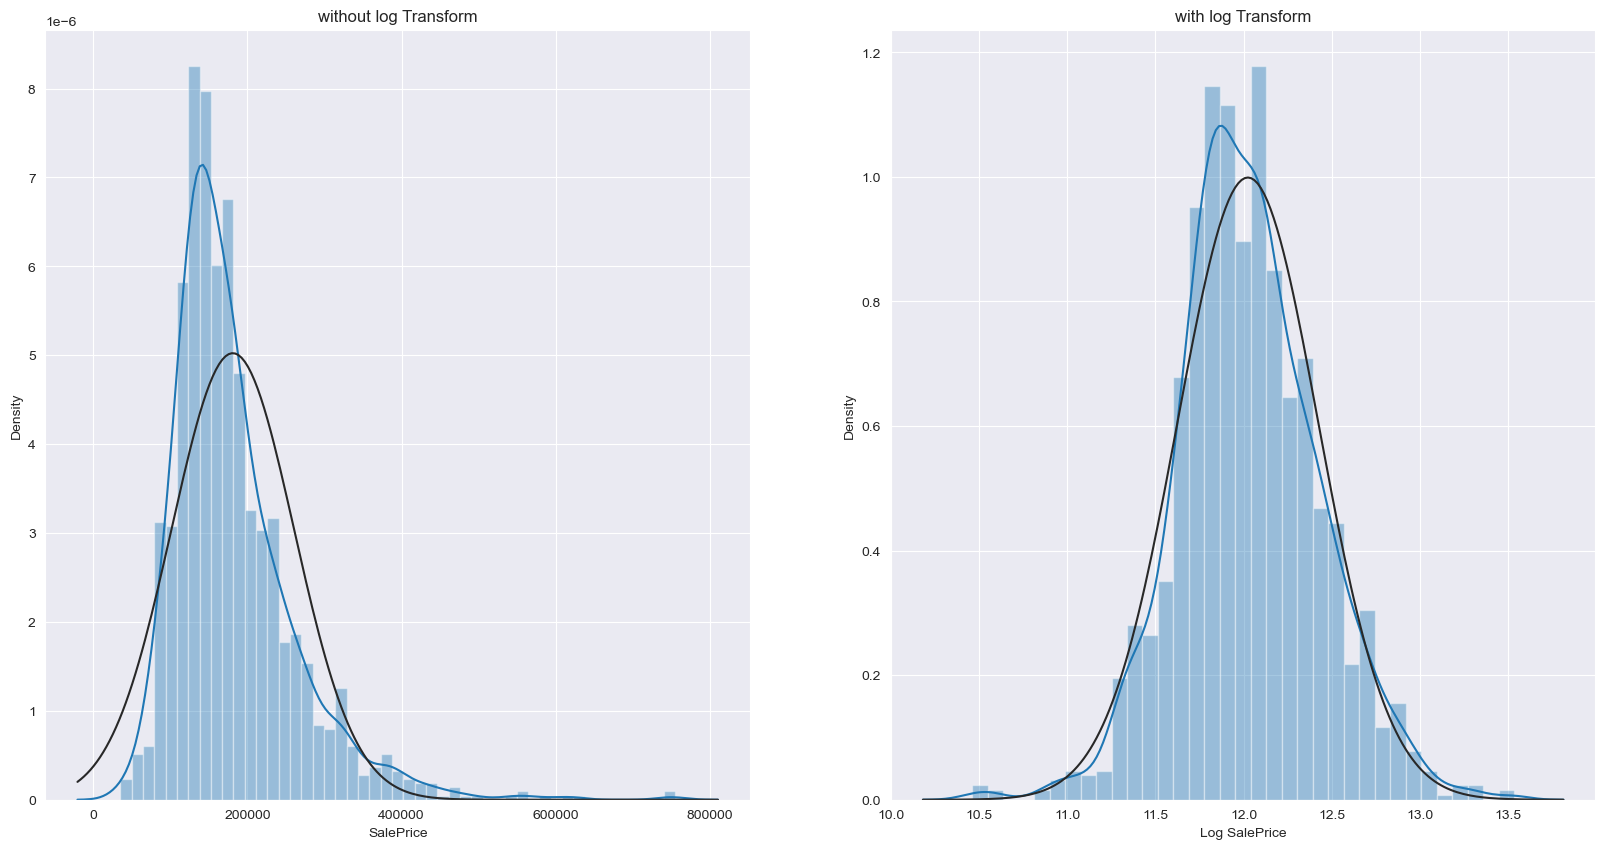

In [32]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(target,kde=True,fit=scipy.stats.norm)
plt.title('without log Transform')

plt.subplot(1,2,2)
sns.distplot(np.log(target),kde=True,fit=scipy.stats.norm)
plt.xlabel('Log SalePrice')
plt.title('with log Transform')

plt.show()

In [33]:
log_target = np.log(target)
log_target

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

# Split Data

In [34]:
train_final = data7.loc[:train0.index.max(),:].copy()
test_final = data7.loc[train0.index.max()+1:,:].reset_index(drop=True).copy()

In [35]:
test_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.536077,0.521437,-0.772552,0.454875,-0.332070,-1.113625,-0.804554,0.645518,2.285649,-0.013563,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.572040,0.923625,-0.063185,0.454875,-0.431241,-1.257229,0.984472,0.873044,-0.363076,0.204364,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.310504,0.862607,-0.772552,-0.435439,0.846305,0.657493,-0.804554,0.821322,-0.363076,-0.375189,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,0.462798,0.222291,-0.063185,0.454875,0.878733,0.657493,0.356462,0.729841,-0.363076,0.083804,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
4,-1.252596,-1.130892,1.355551,-0.435439,0.683917,0.370284,-0.804554,0.452704,-0.363076,0.695621,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-3.284214,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804554,-1.418196,-0.363076,0.362780,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1455,-3.284214,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804554,0.438424,-0.363076,0.031907,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
1456,2.549545,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804554,0.967658,-0.363076,-3.015455,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
1457,-0.200527,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804554,0.535612,-0.363076,0.390461,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


# 6. Models

In [36]:
#_ = setup(data=pd.concat([train_final,log_target],axis=1),target = 'SalePrice')

In [37]:
#compare_models()

Top8: Catboost; br; huber; ridge; omp; lightgbm; gbr; xgboost

# Model: Ridge

In [38]:
model2 = Ridge()

In [39]:
model2.fit(train_final,log_target)

Ridge()

https://scikit-learn.org/stable/modules/model_evaluation.html

In [40]:
kf = KFold(n_splits=10)
results2 = cross_val_score(model2,train_final,log_target,scoring='neg_mean_squared_error',cv=kf)
    #apply cross validation to 'train final'

In [41]:
-results2

array([0.01591245, 0.01126776, 0.01463456, 0.02588732, 0.02210899,
       0.02369018, 0.01595593, 0.00970524, 0.03739105, 0.01611522])

In [42]:
np.mean(-results2) #average of MSE:log_target

0.019266868744610182

<Figure size 1600x1000 with 0 Axes>

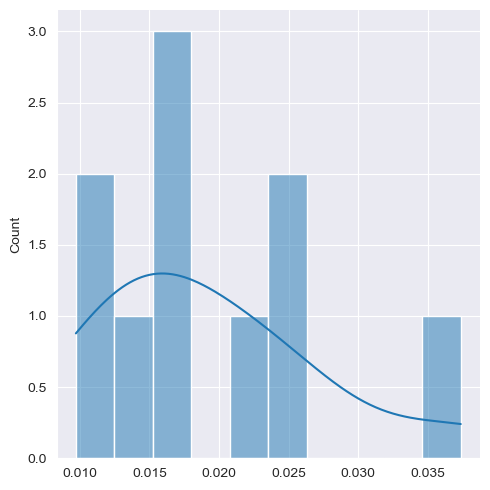

In [43]:
plt.figure(figsize=(16,10))
sns.displot(-results2, bins =10,kde=True)

In [44]:
np.sqrt(np.mean(-results2)) #RSME:log_target

0.1388051466791134

In [45]:
np.exp(np.sqrt(np.mean(-results2))) #RSME:target

1.1489002111700584

In [46]:
#target.describe

# 7. Submission

In [47]:
model2.predict(test_final)

array([11.70596345, 12.03671124, 12.14487185, ..., 12.07399641,
       11.7057828 , 12.2777187 ])

In [48]:
final_predictions = np.exp(model2.predict(test_final))

submission2 = pd.concat([test_ids,pd.Series(final_predictions, name='SalePrice')],axis=1)
submission2

,Id,SalePrice
0,1461,121292.886763
1,1462,168840.749053
2,1463,188126.869951
3,1464,203847.898387
4,1465,196754.609766
...,...,...
1454,2915,84647.939559
1455,2916,80871.213547
1456,2917,175254.838496
1457,2918,121270.976631


In [49]:
#submission.to_csv('submission2.csv',index=False,header=True)